# 1.0 An end-to-end classification problem



## 1.1 Dataset description



We'll be looking at individual income in the United States. The **data** is from the **1994 census**, and contains information on an individual's **marital status**, **age**, **type of work**, and more. The **target column**, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than **50k a year**.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

Let's take the following steps:

1. Load Libraries
2. Get data, including EDA
3. Clean, prepare and manipulate Data (feature engineering)
4. Modeling (train and test)
5. Algorithm Tuning
6. Finalizing the Model


## 1.2 Load Libraries

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 6.8MB 4.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import sklearn
sklearn.__version__

'0.23.2'

In [4]:
!pip install --upgrade pivottablejs

Requirement already up-to-date: pivottablejs in /usr/local/lib/python3.6/dist-packages (0.9.0)


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

# Rich visual representation of estimators (new 0.23.2)
from sklearn import set_config
set_config(display='diagram')

from pivottablejs import pivot_ui
from IPython.display import HTML

## 1.3 Get data & EDA

### 1.3.1 Import the dataset

In [7]:
# columns used 
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 
           'sex','capital_gain', 'capital_loss', 'hours_per_week',
           'native_country','high_income']
# importing the dataset
income = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                   header=None,
                   names=columns)
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1.3.2 EDA

In [8]:
pivot_ui(income, outfile_path='pivottablejs.html')
HTML("pivottablejs.html")

Output hidden; open in https://colab.research.google.com to view.

## 1.4  Clean, prepare and manipulate Data (feature engineering)

This dataset contains a mix of **categorical (9 columns)** and **numerical (6 columns)** independent variables which as we know will need to pre-processed in different ways and separately.

This means that initially they’ll have to go through **separate pipelines** to be pre-processed appropriately and then we’ll combine them together. So the first step in both pipelines would have to be to extract the appropriate columns that need to be pushed down for pre-processing.

### 1.4.1 Removal duplications

In [9]:
# There are duplicated rows
income.duplicated().sum()

24

In [10]:
# Delete duplicated rows
income.drop_duplicates(inplace=True)
income.duplicated().sum()

0

### 1.4.2 Removal Outliers

In [11]:
# Verify if columns[int64] has outliers (with data leakage!!!!!!!)

# data
x = income.select_dtypes("int64")

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

print("Income shape [original]: {}".format(income.shape))
print("Income shape [outlier removal]: {}".format(income.loc[mask,:].shape))

# income with outliner
income_w = income.loc[mask,:].copy()
income_w.head()

Income shape [original]: (32537, 15)
Income shape [outlier removal]: (30977, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K


### 1.4.3 Encoding target variable

If a categorical target variable needs to be encoded for a classification predictive modeling problem, then the [LabelEncoder class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) can be used.

In [12]:
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transoform y_train
income_w["high_income"] = le.fit_transform(income_w.high_income)

In [13]:
le.classes_

array([' <=50K', ' >50K'], dtype=object)

In [14]:
income_w.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,0


## 1.5 Pipeline 

### 1.5.1 Column extractor

In [15]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

### 1.5.2 Categorical transformation

In [16]:
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes one boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 

  def get_feature_names(self):
        return self.colnames.tolist()

  # Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()

    # customize feature?
    # how can I identify this one? EDA!!!!
    if self.new_features: 
      
      # minimize the cardinality of native_country feature
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

      # replace ? with Unknown
      edit_cols = ['native_country','occupation','workclass']
      for col in edit_cols:
        df.loc[df[col] == ' ?', col] = 'unknown'

      # decrease the cardinality of education feature
      hs_grad = [' HS-grad',' 11th',' 10th',' 9th',' 12th']
      elementary = [' 1st-4th',' 5th-6th',' 7th-8th']
      # replace
      df['education'].replace(to_replace = hs_grad,value = 'HS-grad',inplace = True)
      df['education'].replace(to_replace = elementary,value = 'elementary_school',inplace = True)

      # adjust marital_status feature
      married= [' Married-spouse-absent',' Married-civ-spouse',' Married-AF-spouse']
      separated = [' Separated',' Divorced']
      # replace 
      df['marital_status'].replace(to_replace = married ,value = 'Married',inplace = True)
      df['marital_status'].replace(to_replace = separated,value = 'Separated',inplace = True)

      # adjust workclass feature
      self_employed = [' Self-emp-not-inc',' Self-emp-inc']
      govt_employees = [' Local-gov',' State-gov',' Federal-gov']
      # replace elements in list.
      df['workclass'].replace(to_replace = self_employed ,value = 'Self_employed',inplace = True)
      df['workclass'].replace(to_replace = govt_employees,value = 'Govt_employees',inplace = True)

    # update column names
    self.colnames = df.columns      
  
    return df

#### 1.5.2.1 Evaluate

In [17]:
# 
# for validation purposes
#
model = FeatureSelector(income_w.select_dtypes("object").columns.to_list())
df = model.fit_transform(income_w)
df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
5,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States
6,Private,9th,Married-spouse-absent,Other-service,Not-in-family,Black,Female,Jamaica


In [18]:
# 
# for validation purposes
#
model = CategoricalTransformer(new_features=True)
df_cat = model.fit_transform(df)
df_cat.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
1,Self_employed,Bachelors,Married,Exec-managerial,Husband,White,Male,United-States
3,Private,HS-grad,Married,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married,Prof-specialty,Wife,Black,Female,non_usa
5,Private,Masters,Married,Exec-managerial,Wife,White,Female,United-States
6,Private,HS-grad,Married,Other-service,Not-in-family,Black,Female,non_usa


In [19]:
# check the cardinality before and after transformation
income_w.select_dtypes("object").apply(pd.Series.nunique)

workclass          9
education         16
marital_status     7
occupation        15
relationship       6
race               5
sex                2
native_country    41
dtype: int64

In [20]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

workclass          6
education         10
marital_status     4
occupation        15
relationship       6
race               5
sex                2
native_country     2
dtype: int64

### 1.5.3 Numerical transformation

In [23]:
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
  # Class constructor method that takes a model parameter as its argument
  # model 0: minmax
  # model 1: standard
  # model 2: without scaler
  def __init__(self, model = 0):
    self.model = model
    self.colnames = None

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self

  # return columns names after transformation
  def get_feature_names(self):
        return self.colnames 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    
    # update columns name
    self.colnames = df.columns.tolist()
    
    # minmax
    if self.model == 0: 
      scaler = MinMaxScaler()
      # transform data
      df = scaler.fit_transform(df)
    elif self.model == 1:
      scaler = StandardScaler()
      # transform data
      df = scaler.fit_transform(df)
    else:
      df = df.values

    return df

#### 1.5.3.1 Evaluate

In [24]:
# 
# for validation purposes
#
model = FeatureSelector(income_w.select_dtypes("int64").columns.to_list()[:-1])
df = model.fit_transform(income_w)
df.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
1,50,83311,13,0,0,13
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40
5,37,284582,14,0,0,40
6,49,160187,5,0,0,16


In [27]:
# 
# for validation purposes
#
model = NumericalTransformer(model=1)
df_cat = model.fit_transform(df)
df_cat

array([[ 0.85120514, -1.02164688,  1.14880104, -0.13527006, -0.15610197,
        -2.22744039],
       [ 1.072318  ,  0.4510003 , -1.19518591, -0.13527006, -0.15610197,
        -0.03183757],
       [-0.77028913,  1.45949275,  1.14880104, -0.13527006, -0.15610197,
        -0.03183757],
       ...,
       [ 1.44083943, -0.35443782, -0.41385693, -0.13527006, -0.15610197,
        -0.03183757],
       [-1.21251484,  0.12778824, -0.41385693, -0.13527006, -0.15610197,
        -1.65821003],
       [ 0.99861371,  0.96849364, -0.41385693,  1.99827386, -0.15610197,
        -0.03183757]])

### 1.5.4 Pipeline union (cat + num)

In [28]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(income_w.drop(labels="high_income",axis=1),
                                                    income_w["high_income"],
                                                    test_size=0.20,
                                                    random_state=41,
                                                    shuffle=True,
                                                    stratify=income_w["high_income"])

In [35]:
# Categrical features to pass down the categorical pipeline 
categorical_features = X_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = X_train.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer()),
                                         ('cat_encoder','passthrough')
                                         #('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                         ]
                                )

# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('num_transformer', NumericalTransformer()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                               ('num_pipeline', numerical_pipeline)
                                                               ]
                                           )

#### 1.5.4.1 Evaluate

In [ ]:
# 
# for validate purposes
#
new_data = full_pipeline_preprocessing.fit_transform(X_train)
catnames = full_pipeline_preprocessing.get_params()["cat_pipeline"][2].get_feature_names().tolist()
numnames = full_pipeline_preprocessing.get_params()["num_pipeline"][1].get_feature_names()
df = pd.DataFrame(new_data,columns = catnames + numnames)
df.head()

In [ ]:
df.shape

(24781, 48)

## 1.6 Algorithm tuning

In [36]:
# global varibles
seed = 15
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

In [37]:
# See documentation for more info
# https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs",SelectKBest()),
                         ("classifier",DecisionTreeClassifier())])
# create a dictionary with the hyperparameters
search_space = [{"classifier":[DecisionTreeClassifier()],
                 "classifier__criterion": ["entropy"],  #["gini","entropy"],
                 "classifier__splitter": ["best"],
                 "fs__k":[15],  # [10,15,20] 
                 "fs__score_func": [chi2],  #[f_classif, mutual_info_classif, chi2],
                 "full_pipeline__cat_pipeline__cat_encoder": [OneHotEncoder(sparse=False,drop="first")], #[OneHotEncoder(sparse=False,drop="first"),
                                                            #OrdinalEncoder()],
                 "full_pipeline__cat_pipeline__cat_transformer__new_features":[True],
                 "full_pipeline__num_pipeline__num_transformer__model": [0]}, #[0,2]},
                {"classifier": [KNeighborsClassifier()],
                "classifier__n_neighbors": [3],
                 "full_pipeline__cat_pipeline__cat_encoder":[OneHotEncoder(sparse=False,drop="first")]}]

# create grid search
kfold = StratifiedKFold(n_splits=num_folds,random_state=seed,shuffle=True)

# see other scoring
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="Accuracy")

# fit grid search
all_models = grid.fit(X_train,y_train)

In [38]:
all_models

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=15, shuffle=True),
             estimator=Pipeline(steps=[('full_pipeline',
                                        FeatureUnion(transformer_list=[('cat_pipeline',
                                                                        Pipeline(steps=[('cat_selector',
                                                                                         FeatureSelector(feature_names=['workclass',
                                                                                                                        'education',
                                                                                                                        'marital_status',
                                                                                                                        'occupation',
                                                                                                                        'relationship',
                                                                                                                        'race',
                                                                                                                        'sex',
                                                                                                                        'native_country'])),
                                                                                        ('cat_transformer',
                                                                                         Ca...
                          'full_pipeline__cat_pipeline__cat_transformer__new_features': [True],
                          'full_pipeline__num_pipeline__num_transformer__model': [0]},
                         {'classifier': [KNeighborsClassifier()],
                          'classifier__n_neighbors': [3],
                          'full_pipeline__cat_pipeline__cat_encoder': [OneHotEncoder(drop='first',
                                                                                     sparse=False)]}],
             refit='Accuracy', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [39]:
print("Best: %f using %s" % (all_models.best_score_,all_models.best_params_))

Best: 0.849885 using {'classifier': DecisionTreeClassifier(criterion='entropy'), 'classifier__criterion': 'entropy', 'classifier__splitter': 'best', 'fs__k': 15, 'fs__score_func': <function chi2 at 0x7f5c00608840>, 'full_pipeline__cat_pipeline__cat_encoder': OneHotEncoder(drop='first', sparse=False), 'full_pipeline__cat_pipeline__cat_transformer__new_features': True, 'full_pipeline__num_pipeline__num_transformer__model': 0}


In [40]:
result = pd.DataFrame(all_models.cv_results_)
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__criterion,param_classifier__splitter,param_fs__k,param_fs__score_func,param_full_pipeline__cat_pipeline__cat_encoder,param_full_pipeline__cat_pipeline__cat_transformer__new_features,param_full_pipeline__num_pipeline__num_transformer__model,param_classifier__n_neighbors,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,split5_test_AUC,split6_test_AUC,split7_test_AUC,split8_test_AUC,split9_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.228308,0.015843,0.072358,0.001032,DecisionTreeClassifier(criterion='entropy'),entropy,best,15,<function chi2 at 0x7f5c00608840>,"OneHotEncoder(drop='first', sparse=False)",True,0,NaN,{'classifier': DecisionTreeClassifier(criterio...,0.892707,0.900312,0.872928,0.881811,0.890946,0.879230,0.882089,0.885924,0.884973,0.874164,0.884509,0.008017,1,0.899510,0.898877,0.900826,0.900238,0.899398,0.901020,0.900340,0.900114,0.900294,0.900353,0.900097,0.000624,0.851956,0.859968,0.837369,0.851897,0.859968,0.843826,0.849475,0.849879,0.847861,0.846651,0.849885,0.006479,1,0.854094,0.853562,0.855714,0.854056,0.853383,0.855221,0.854549,0.854459,0.854773,0.854773,0.854458,0.000680
1,0.934889,0.041264,0.995386,0.013507,KNeighborsClassifier(),NaN,NaN,NaN,NaN,"OneHotEncoder(drop='first', sparse=False)",NaN,NaN,3,"{'classifier': KNeighborsClassifier(), 'classi...",0.821645,0.804754,0.828007,0.810562,0.824323,0.813478,0.799578,0.815597,0.823322,0.806704,0.814797,0.008962,2,0.919186,0.919806,0.920756,0.919328,0.921069,0.918284,0.919031,0.915395,0.922679,0.922547,0.919808,0.002031,0.830980,0.811945,0.811945,0.817191,0.819209,0.809927,0.812752,0.814770,0.822034,0.815174,0.816593,0.005929,2,0.874092,0.875263,0.872708,0.876519,0.875308,0.877685,0.876967,0.873963,0.875174,0.875667,0.875335,0.001416


In [41]:
# Just change column name from "test" to "validation" for not confuse
result_auc = result[['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC',"rank_test_AUC"]].copy()
for col in result_auc.columns:
  result_auc.rename(columns={col:col.replace("test","validation")}, inplace=True)
result_auc

,mean_train_AUC,std_train_AUC,mean_validation_AUC,std_validation_AUC,rank_validation_AUC
0,0.900097,0.000624,0.884509,0.008017,1
1,0.919808,0.002031,0.814797,0.008962,2


In [42]:
# Just change column name from "test" to "validation" for not confuse
result_acc = result[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy',"rank_test_Accuracy"]].copy()
for col in result_acc.columns:
  result_acc.rename(columns={col:col.replace("test","validation")}, inplace=True)
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_validation_Accuracy,std_validation_Accuracy,rank_validation_Accuracy
0,0.854458,0.000680,0.849885,0.006479,1
1,0.875335,0.001416,0.816593,0.005929,2


## 1.7 Finalize the model

In [43]:
# final model
predict = all_models.predict(X_test)

In [44]:
# confusion matrix (we change the way to make equal to slides)
#             true label
#               1     0     
# predict  1    TP    FP
#          0    FN    TN
#

confusion_matrix(predict,y_test,
                 labels=[1,0])

array([[ 842,  299],
       [ 612, 4443]])

In [45]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test,predict))

0.8529696578437702
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4742
           1       0.74      0.58      0.65      1454

    accuracy                           0.85      6196
   macro avg       0.81      0.76      0.78      6196
weighted avg       0.85      0.85      0.85      6196



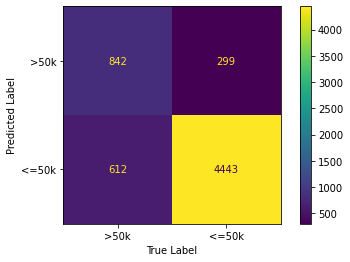

In [46]:
fig, ax = plt.subplots(1,1,figsize=(7,4))

ConfusionMatrixDisplay(confusion_matrix(predict,y_test,labels=[1,0]),
                       display_labels=[">50k","<=50k"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [47]:
# columns used in the model (k columns)
features = all_models.best_estimator_.named_steps['fs']
features.get_support()

array([False, False, False, False, False, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False,  True,  True, False,
       False, False, False, False,  True, False, False, False, False,
        True, False, False])

In [48]:
# All information is trackable going back in the Pipeline
# categorical columns
features_full = all_models.best_estimator_.named_steps['full_pipeline']
features_cat = features_full.get_params()["cat_pipeline"]
features_cat[2].get_feature_names()

array(['x0_ Private', 'x0_ Without-pay', 'x0_Govt_employees',
       'x0_Self_employed', 'x0_unknown', 'x1_ Assoc-voc', 'x1_ Bachelors',
       'x1_ Doctorate', 'x1_ Masters', 'x1_ Preschool', 'x1_ Prof-school',
       'x1_ Some-college', 'x1_HS-grad', 'x1_elementary_school',
       'x2_ Widowed', 'x2_Married', 'x2_Separated', 'x3_ Armed-Forces',
       'x3_ Craft-repair', 'x3_ Exec-managerial', 'x3_ Farming-fishing',
       'x3_ Handlers-cleaners', 'x3_ Machine-op-inspct',
       'x3_ Other-service', 'x3_ Priv-house-serv', 'x3_ Prof-specialty',
       'x3_ Protective-serv', 'x3_ Sales', 'x3_ Tech-support',
       'x3_ Transport-moving', 'x3_unknown', 'x4_ Not-in-family',
       'x4_ Other-relative', 'x4_ Own-child', 'x4_ Unmarried', 'x4_ Wife',
       'x5_ Asian-Pac-Islander', 'x5_ Black', 'x5_ Other', 'x5_ White',
       'x6_ Male', 'x7_non_usa'], dtype=object)

In [ ]:
features_full

FeatureUnion(transformer_list=[('cat_pipeline',
                                Pipeline(steps=[('cat_selector',
                                                 FeatureSelector(feature_names=['workclass',
                                                                                'education',
                                                                                'marital_status',
                                                                                'occupation',
                                                                                'relationship',
                                                                                'race',
                                                                                'sex',
                                                                                'native_country'])),
                                                ('cat_transformer',
                                                 CategoricalTransformer()),
                                                ('cat_encoder',
                                                 OneHotEncoder(drop='first',
                                                               sparse=False))])),
                               ('num_pipeline',
                                Pipeline(steps=[('num_selector',
                                                 FeatureSelector(feature_names=['age',
                                                                                'fnlwgt',
                                                                                'education_num',
                                                                                'capital_gain',
                                                                                'capital_loss',
                                                                                'hours_per_week'])),
                                                ('num_transformer',
                                                 NumericalTransformer())]))])

In [49]:
# numerical columns
features_full.get_params()["num_pipeline"][1].get_feature_names()

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [50]:
all_columns = features_cat[2].get_feature_names().tolist() + features_full.get_params()["num_pipeline"][1].get_feature_names()
all_columns

['x0_ Private',
 'x0_ Without-pay',
 'x0_Govt_employees',
 'x0_Self_employed',
 'x0_unknown',
 'x1_ Assoc-voc',
 'x1_ Bachelors',
 'x1_ Doctorate',
 'x1_ Masters',
 'x1_ Preschool',
 'x1_ Prof-school',
 'x1_ Some-college',
 'x1_HS-grad',
 'x1_elementary_school',
 'x2_ Widowed',
 'x2_Married',
 'x2_Separated',
 'x3_ Armed-Forces',
 'x3_ Craft-repair',
 'x3_ Exec-managerial',
 'x3_ Farming-fishing',
 'x3_ Handlers-cleaners',
 'x3_ Machine-op-inspct',
 'x3_ Other-service',
 'x3_ Priv-house-serv',
 'x3_ Prof-specialty',
 'x3_ Protective-serv',
 'x3_ Sales',
 'x3_ Tech-support',
 'x3_ Transport-moving',
 'x3_unknown',
 'x4_ Not-in-family',
 'x4_ Other-relative',
 'x4_ Own-child',
 'x4_ Unmarried',
 'x4_ Wife',
 'x5_ Asian-Pac-Islander',
 'x5_ Black',
 'x5_ Other',
 'x5_ White',
 'x6_ Male',
 'x7_non_usa',
 'age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week']

In [ ]:
selected_columns = [value for (value, filter) in zip(all_columns, features.get_support()) if filter]
selected_columns

['x1_ Bachelors',
 'x1_ Doctorate',
 'x1_ Masters',
 'x1_ Prof-school',
 'x1_HS-grad',
 'x2_Married',
 'x2_Separated',
 'x3_ Exec-managerial',
 'x3_ Other-service',
 'x3_ Prof-specialty',
 'x4_ Not-in-family',
 'x4_ Own-child',
 'x4_ Unmarried',
 'x6_ Male',
 'capital_gain']

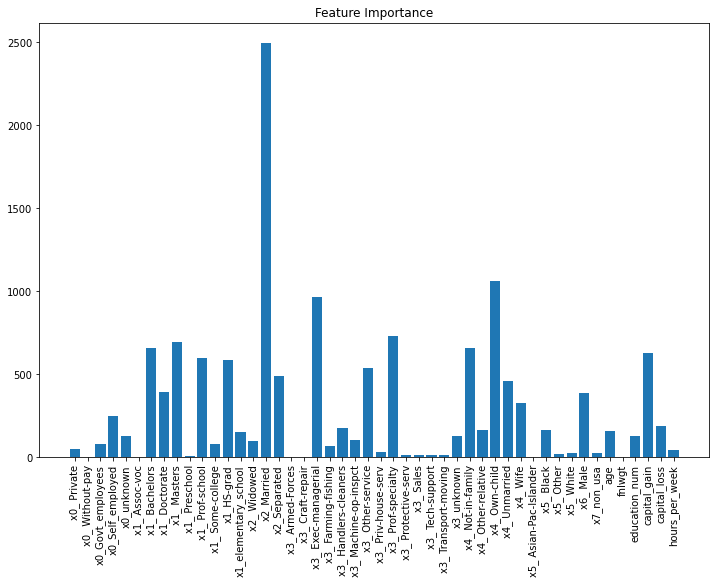

In [51]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

xticks = [x for x in range(len(features.scores_))] 
ax.bar(xticks, features.scores_)
ax.set_xticks(xticks)
ax.set_xticklabels(all_columns,rotation=90)
#ax.set_xticks(ticks=xticks, labels=all_columns,rotation=90,fontsize=15)
ax.set_title("Feature Importance")
plt.show()

In [52]:
all_models.best_estimator_.named_steps['classifier']

DecisionTreeClassifier(criterion='entropy')

[Text(641.0464791680835, 397.5075, 'x1_ Assoc-voc <= 0.5\nentropy = 0.786\nsamples = 24781\nvalue = [18968, 5813]\nclass = <=50k'),
 Text(490.4038941359494, 377.1225, 'x2_ Widowed <= 0.083\nentropy = 0.331\nsamples = 13144\nvalue = [12344, 800]\nclass = <=50k'),
 Text(488.5823489781692, 356.7375, 'x1_ Some-college <= 0.5\nentropy = 0.28\nsamples = 12972\nvalue = [12344, 628]\nclass = <=50k'),
 Text(401.30027330998365, 336.35249999999996, 'x0_unknown <= 0.5\nentropy = 0.349\nsamples = 9203\nvalue = [8601, 602]\nclass = <=50k'),
 Text(337.59422181039173, 315.9675, 'x0_ Without-pay <= 0.5\nentropy = 0.456\nsamples = 5272\nvalue = [4766, 506]\nclass = <=50k'),
 Text(288.1100975924918, 295.5825, 'x0_Self_employed <= 0.5\nentropy = 0.436\nsamples = 5197\nvalue = [4730, 467]\nclass = <=50k'),
 Text(227.8496837595212, 275.1975, 'x1_ Doctorate <= 0.5\nentropy = 0.415\nsamples = 5103\nvalue = [4676, 427]\nclass = <=50k'),
 Text(149.33824129488573, 254.8125, 'x1_ Preschool <= 0.5\nentropy = 0.359

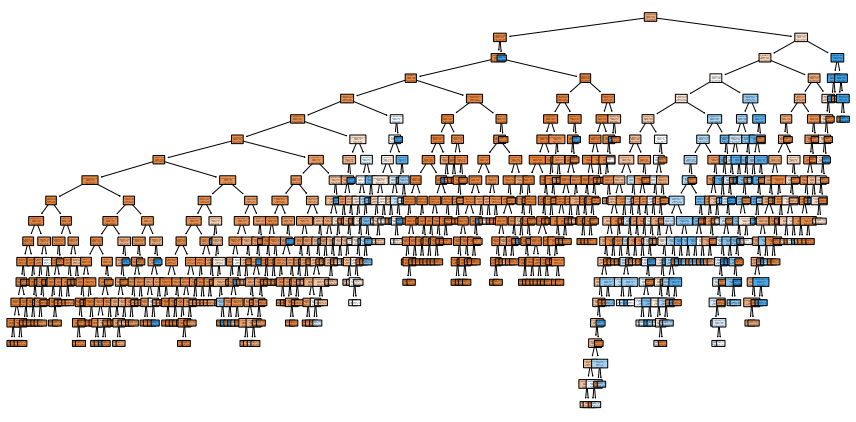

In [53]:
from sklearn.tree import plot_tree # to draw a classification tree
plt.figure(figsize=(15, 7.5))
plot_tree(all_models.best_estimator_.named_steps['classifier'], 
          filled=True, 
          rounded=True, 
          class_names=["<=50k", ">50k"],
          feature_names=all_columns)

In [ ]:
# Save the model using joblib
with open('pipe.joblib', 'wb') as file:
  joblib.dump(all_models, file)

In [ ]:
# Under the production environment [joblib]
with open('pipe.joblib', 'rb') as file:
  model = joblib.load(file)

# final model
predict = model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, predict))
print(classification_report(y_test,predict))

0.8529696578437702
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4742
           1       0.74      0.58      0.65      1454

    accuracy                           0.85      6196
   macro avg       0.81      0.76      0.78      6196
weighted avg       0.85      0.85      0.85      6196



## 1.8 Next

- Other models using Ensemble

# References

1. https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900
2. https://towardsdatascience.com/machine-learning-feature-encoding-with-onehotencoder-inside-a-pipeline-76d440940f4b